In [2]:
!pip install tensorflow==2.0.0b1

  Created wheel for absl-py: filename=absl_py-0.8.1-cp37-none-any.whl size=121171 sha256=abc0cc5c4144dee096158aeca1d9cb37013cf045aafbb514fd79ed298dcf5f4f
  Stored in directory: C:\Users\user\AppData\Local\pip\Cache\wheels\a7\15\a0\0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
  Created wheel for gast: filename=gast-0.3.2-cp37-none-any.whl size=9684 sha256=28081fa9f0f9e68a59d876489bd3628d933ceee3c83c6b9347f32c311d344a68
  Stored in directory: C:\Users\user\AppData\Local\pip\Cache\wheels\59\38\c6\234dc39b4f6951a0768fbc02d5b7207137a5b1d9094f0d54bf
  Created wheel for termcolor: filename=termcolor-1.1.0-cp37-none-any.whl size=4835 sha256=f6f35a3e0f66d18e8c14c9d348d86cd044c609ab79a1aceea9cf5e41a74054b1
  Stored in directory: C:\Users\user\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built absl-py gast termcolor


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def plot_series(time, series, format="-",start=0,end=None):
    plt.plot(time[start:end],series[start:end],format)
    plt.xlabel("Time")
    plt.ylabel("meter reading")
    plt.grid(True)

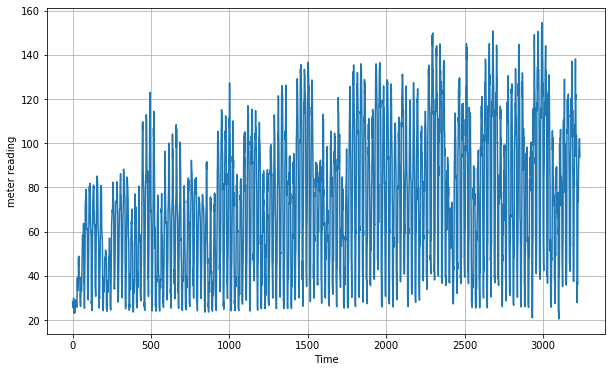

In [42]:
r=pd.read_csv("timetrain.csv")
series = np.array(r['meter_reading'])
time_step=[]
for x in range(len(series)):
    time_step.append(x)
time=np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time,series)

In [43]:
r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 2 columns):
timestamp        3235 non-null object
meter_reading    3235 non-null float64
dtypes: float64(1), object(1)
memory usage: 50.7+ KB


In [44]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [45]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [46]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [47]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [48]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=30, callbacks=[lr_schedule])

Epoch 1/30
12/12 [==============================] - 6s 514ms/step - loss: 70.5588 - mae: 71.1219
Epoch 2/30
12/12 [==============================] - 3s 258ms/step - loss: 64.2657 - mae: 64.8024
Epoch 3/30
12/12 [==============================] - 3s 289ms/step - loss: 59.4166 - mae: 59.9782
Epoch 4/30
12/12 [==============================] - 4s 294ms/step - loss: 53.4359 - mae: 53.9980
Epoch 5/30
12/12 [==============================] - 3s 284ms/step - loss: 47.2201 - mae: 47.7679
Epoch 6/30
12/12 [==============================] - 3s 288ms/step - loss: 41.4721 - mae: 41.9907
Epoch 7/30
12/12 [==============================] - 3s 287ms/step - loss: 36.7638 - mae: 37.2460
Epoch 8/30
12/12 [==============================] - 3s 285ms/step - loss: 33.2375 - mae: 33.6884
Epoch 9/30
12/12 [==============================] - 3s 288ms/step - loss: 30.7227 - mae: 31.1548
Epoch 10/30
12/12 [==============================] - 4s 293ms/step - loss: 28.9116 - mae: 29.3338
Epoch 11/30
12/12 [==========

[1e-08, 0.0001, 0, 60]

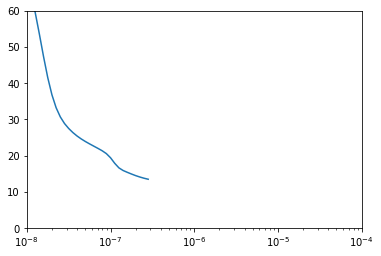

In [49]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [50]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)

Epoch 1/30
30/30 [==============================] - 7s 247ms/step - loss: 17.2946 - mae: 17.8886
Epoch 2/30
30/30 [==============================] - 4s 139ms/step - loss: 10.8709 - mae: 11.3584
Epoch 3/30
30/30 [==============================] - 4s 144ms/step - loss: 8.7195 - mae: 9.1905
Epoch 4/30
30/30 [==============================] - 4s 140ms/step - loss: 7.8572 - mae: 8.3145
Epoch 5/30
30/30 [==============================] - 4s 139ms/step - loss: 7.3741 - mae: 7.8351
Epoch 6/30
30/30 [==============================] - 4s 138ms/step - loss: 7.2414 - mae: 7.7022
Epoch 7/30
30/30 [==============================] - 4s 139ms/step - loss: 7.0323 - mae: 7.5008
Epoch 8/30
30/30 [==============================] - 4s 137ms/step - loss: 6.8110 - mae: 7.2603
Epoch 9/30
30/30 [==============================] - 4s 140ms/step - loss: 6.5924 - mae: 7.0583
Epoch 10/30
30/30 [==============================] - 4s 140ms/step - loss: 6.4829 - mae: 6.9486
Epoch 11/30
30/30 [==========================

In [51]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

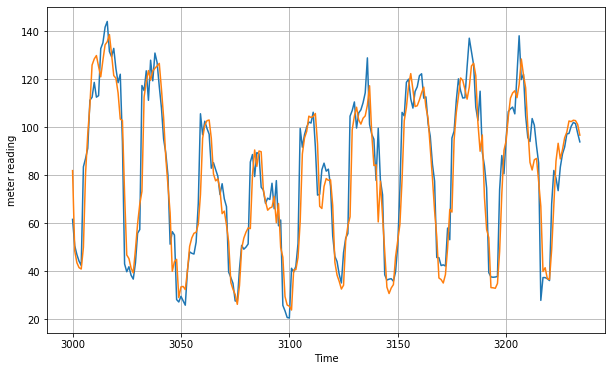

In [52]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)